Аэродинамика
---
Вычисления для курсача по самолету ЯК-141

Исходные данные, для выполнения работы.
В коментах написано что за что отвечает.
Менять переменные нужно только в блоке ниже, все остальное уже зависит от них

In [1]:
# Отклонение от стандартной атмосферы
H = 6000
detT = -5

In [2]:
#Фюзеляж
f_params = [
    # Название, длинна, диаметр
    # Фюзеляж обязательно первый.
    ["Фюзеляж", 17.00, 1.92],
    ["Цилиндрическая часть", 11.66-4.1, 1.92],
    ["Носовая часть", 4.1, 0.88],
    ["Кормовая часть", 17 -11.66, 1.27],
]

In [3]:
#Несущие поверхности (w - wing)
# Крыло -> Название, элементы, повторения
# Элеметн крыла -> b_0, b_k, l, X
w_params = [
    "Крыло", 
    [
        [5.07, 3.243, 2.620, 40], 
        [3.243, 1.39, 9.81/2-2.620, 40]
    ],
    2
]
ho_params = ["ГО", [[3.921, 0.210, 4.854/2]], 2]
vo_params = ["ВО", [[2.556, 0.210, 2.771]], 2]

#Параметры для консольных частей (без учета части, которая в фюзеляже)
w_params_k = [
    "Крыло", 
    [
        [4.198, 3.243, 2.620 - 1.92/2, 40], 
        [3.243, 1.39, 9.81/2-(2.620 - 1.92/2), 40]
    ],
    2
]
ho_params_k = ["ГО", [[2.7, 0.210, 1.163]], 2]
vo_params_k = ["ВО", [[1.92, 0.210, 2.02]], 2]

all_M = [0.2, 0.4, 0.8, 1.3, 1.6, 1.8]

#толщина профиля
c_max = 0.203
c_ = c_max / w_params[1][0][0]
c_

0.040039447731755426

Константы для вычислений

In [4]:
g0 = 9.80665
R = 287.05287
PR = 10.1972

Импорты для работы и функции для асиста

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

Таблицы с коэфициентами
(Функции, выдающие нам нужные для рассчетов значения, в зависимости от исходных данных)

In [6]:
def hg0(hg):
    if (0 <= hg and hg < 11000.0): return 0.0
    if (11000.0 <= hg and hg < 20000.0): return 11000.0
    if (20000.0 <= hg): return 20000.0

def t0(hg):
    if (0 <= hg and hg < 11000.0): return 288.15
    if (11000.0 <= hg and hg < 20000.0): return 216.65
    if (20000.0 <= hg): return 216.65

def p0(hg):
    if (0 <= hg and hg < 11000.0): return 1013.25
    if (11000.0 <= hg and hg < 20000.0): return 226.32
    if (20000.0 <= hg): return 54.7487


def b0(hg):
    if (0 <= hg and hg < 11000.0): return -0.0065
    if (11000.0 <= hg and hg < 20000.0): return 0.0
    if (20000.0 <= hg): return 0.001

pd.DataFrame([
    ["Hg 0", hg0(0), hg0(15000), hg0(30000)],
    ["T 0", t0(0), t0(15000), t0(30000)],
    ["P 0", p0(0), p0(15000), p0(30000)],
    ["B 0", b0(0), b0(15000), b0(30000)],], 
    columns=["Параметр", "Hg < 11000", "11000 <= Hg < 20000", "20000 <= Hg "],
)

,Параметр,Hg < 11000,11000 <= Hg < 20000,20000 <= Hg
0,Hg 0,0.0000,11000.00,20000.0000
1,T 0,288.1500,216.65,216.6500
2,P 0,1013.2500,226.32,54.7487
3,B 0,-0.0065,0.00,0.0010


Вычисление параметров стандартной атмосферы
---
Под этим блоком выводятся все необходимые данные по атмосфере

In [7]:
from math import *

hg = (6356766.0 * H) / (6356766.0 + H)
detH = hg - hg0(hg)
T = t0(hg) + b0(hg)*detH + detT
P = p0(hg) * exp((-g0 * detH) / (R * t0(hg))) if (11000.0 <= hg and hg < 20000.0 ) else p0(hg)* pow(1 + b0(hg)/t0(hg)*detH, -g0 /(b0(hg)* R))
ro = (P * PR) / (R * T)
a = 20.046796 * sqrt(T)

pd.DataFrame([[H, detT, hg, detH, T, P, ro, a]], columns=["H", "detT", "hg", "detH", "T", "P", "ro", "a"])

,H,detT,hg,detH,T,P,ro,a
0,6000,-5,5994.342083,5994.342083,244.186776,472.176171,0.068691,313.260792


Определение геометрических параметров фюзеляжа
---
Тут просто нормально отображаются данные введенные в начале + считаются некоторые параметры.

In [8]:
#sample_str[ 0 : N ]
tableData = []
for part in f_params:
    tableData.append([part[0] + " (длина)", "L_" +str(part[0][0:3]), part[1]])
for part in f_params:
    tableData.append([part[0] + " (диаметр)", "D_" +str(part[0][0:3]), part[2]])
for part in f_params:
    tableData.append([part[0] + " (удлинение)", "Lambda_" +str(part[0][0:3]), (part[1]/f_params[0][2])])
for part in f_params:
    n = part[2]/f_params[0][2]
    if n != 1: tableData.append([part[0] + " (Сужение)", "n" +str([part[0][0:3]]), n])
pd.DataFrame(tableData, columns=["Название", "Обозначение", "Значение"])

,Название,Обозначение,Значение
0,Фюзеляж (длина),L_Фюз,17.000000
1,Цилиндрическая часть (длина),L_Цил,7.560000
2,Носовая часть (длина),L_Нос,4.100000
3,Кормовая часть (длина),L_Кор,5.340000
4,Фюзеляж (диаметр),D_Фюз,1.920000
5,Цилиндрическая часть (диаметр),D_Цил,1.920000
6,Носовая часть (диаметр),D_Нос,0.880000
7,Кормовая часть (диаметр),D_Кор,1.270000
8,Фюзеляж (удлинение),Lambda_Фюз,8.854167
9,Цилиндрическая часть (удлинение),Lambda_Цил,3.937500


Определение геометрических параметров несущей поверхности
---
Рассчитаем следующие относительные геометрические параметры несущей поверхности:

In [9]:
def wing_l(wing, c = -1):
    l = 0
    for part in wing[1]:
        l += part[2]
    return l * (wing[2] if c < 0 else c)

def wing_s(wing, c = -1):
    s = 0
    for part in wing[1]:
        s += (part[0] + part[1]) / 2 * part[2]
    return s * (wing[2] if c < 0 else c)

def wing_x(wing):
    return wing[1][0][3]

def lambd(wing):
    return  pow(wing_l(wing), 2)/wing_s(wing)

def n(wing):
    return wing[1][0][0]/wing[1][-1][1]

In [10]:
tableData = [
    ["Размах крыла", "l", wing_l(w_params)],
    ["Площадь крыла", "S", wing_s(w_params)],
    ["Размах консольной части крыла", "l_ккр", wing_l(w_params_k)],
    ["Площадь консольной части крыла", "S_ккр", wing_s(w_params_k)],
    ["Высота вертикального оперения", "l_во", wing_l(vo_params, 1)],
    ["Площадь вертикального оперения", "S_во", wing_s(vo_params, 1)],
    ["Концевая хорда крыла", "b_k", w_params[1][-1][1]],
    ["Корневая хорда крыла", "b_б", w_params_k[1][0][0]],
    ["Центральная хорда крыла", "b_0", w_params[1][0][0]],
    ["Удлинение несущей поверхности", "lambda", lambd(w_params)],
    ["Удлинение консольной части несущей поверхности", "lambda_k", lambd(w_params_k)],
    ["Удлинение ВО", "lambda_во", lambd(vo_params_k)],
    ["Сужение несущей поверхности с подф. частью", "n", n(w_params)],
    ["Сужение консольной части несущей поверхности", "n_k", n(w_params_k)],
    ["Размах горизонтального оперения", "l_го", wing_l(ho_params, 1)],
    ["Площадь горизонтального оперения", "S_го", wing_s(ho_params, 1)],
    ["Размах консольной части ГО", "l_го", wing_l(ho_params_k, 1)],
    ["Площадь консольной части ГО", "S_го", wing_s(ho_params_k, 1)],
    ["Концевая хорда ГО", "b_kго", ho_params_k[1][-1][1]],
    ["Корневая хорда ГО", "b_бго", ho_params_k[1][0][0]],
    ["Удлинение ГО", "lambda_го", lambd(ho_params)],
    ["Удлинение консольной части ГО", "lambda_kго", lambd(ho_params_k)],
    ["Сужение ГО", "n_го", n(ho_params)],
    ["Сужение консольной части ГО", "n_kго", n(ho_params_k)],
]
pd.DataFrame(tableData, columns=["Название", "Обозначение", "Значение"])

,Название,Обозначение,Значение
0,Размах крыла,l,9.810000
1,Площадь крыла,S,32.366465
2,Размах консольной части крыла,l_ккр,9.810000
3,Площадь консольной части крыла,S_ккр,27.386145
4,Высота вертикального оперения,l_во,2.771000
5,Площадь вертикального оперения,S_во,3.832293
6,Концевая хорда крыла,b_k,1.390000
7,Корневая хорда крыла,b_б,4.198000
8,Центральная хорда крыла,b_0,5.070000
9,Удлинение несущей поверхности,lambda,2.973327


Определение САХ крыла
---
Сах определяется путем разбиения сложного крыла на простые состовные части, путем опрелеления САХ для каждой секции.
Сначала определяем САХ полного крыла с подфюзеляжной частью.

In [11]:
def toRad(grad):
    return grad / 1800 * pi

def SAH_simple(b_0, b_k, l, X_pk):
    S = (b_0 + b_k) / 2 * l
    b = (2/3)*(b_0 + b_k - b_0*b_k/(b_0+b_k))
    z = (b_0 + 2*b_k)/(b_0 + b_k) * (l/6)
    x = z * tan(toRad(X_pk))
    return b, z, x, S

def SAH(wing):
    b_topSum = 0
    z_topSup = 0
    x_topSum = 0
    bototmSum = 0
    l = 0
    for part in wing[1]:
        l += part[2] * 2
        b, z, x, S = SAH_simple(part[0], part[1], part[2], part[3])
        b_topSum += b*S
        z_topSup += z*S
        x_topSum += x*S
        bototmSum += S
    return b_topSum/bototmSum, z_topSup/bototmSum, x_topSum/bototmSum

Вычисление САХ

In [12]:
b, z, x = SAH(w_params)
tableData = [["САХ сложного крылв", b, z, x]]
pd.DataFrame(tableData, columns=[ "","b", "z", "x"])

,,b,z,x
0,САХ сложного крылв,3.640108,0.570407,0.039887


Вычисление САХ консольной части крыла

In [13]:
b, z, x = SAH(w_params_k)
tableData = [["САХ сложного крылв", b, z, x]]
pd.DataFrame(tableData, columns=[ "","b", "z", "x"])

,,b,z,x
0,САХ сложного крылв,3.026773,0.565147,0.039519


Определение критического числа Маха
---
Критическое число Маха самолета можно считать равным M_кр крыла для нормальной аэродинамической схемы.
Так как аэродинамические коэффициенты фюзеляжа в трансзвуковом диапазоне чисел Маха изменяются более плавно, чем соответствующие коэффициенты крыла или ПГО, то вполне допустимо пренебречь значением M_кр фюзеляжа, меньшим по величине числа M_кр крыла или ПГО.

In [14]:
wing = w_params
l = pow(wing_l(wing), 2) / wing_s(wing)
x = wing_x(wing)

Cya = 0
M_krpr = 1 - 0.7 * sqrt(c_) - 3.2 * c_ * pow(Cya, 1.5)

tableData = [
    ["Мах критический профиля", "Mкр пр", M_krpr],
    ["Угол стреловидности", "X", x],
    ["Удлинение", "lambd", l]
]
pd.DataFrame(tableData, columns=[ "","Обозначение", "Значение"])

,,Обозначение,Значение
0,Мах критический профиля,Mкр пр,0.859931
1,Угол стреловидности,X,40.000000
2,Удлинение,lambd,2.973327


Теперт выбираем по графикам два значения

![alt text](images/mkr.png "Title")

In [15]:
M_kr_l = 0.01
M_kr_x = 0.09

M_kr = M_krpr + M_kr_l + M_kr_x

tableData = [
    ["Мах критический", "Mкр", M_kr],
]
pd.DataFrame(tableData, columns=[ "","Обозначение", "Значение"])

,,Обозначение,Значение
0,Мах критический,Mкр,0.959931


Определение коэффициента подъемной силы самолета
---
Тут мы находим относительные площади несущих поверхностей относительно полной площади крыла

In [16]:
S = wing_s(w_params)
S_kkr = wing_s(w_params_k)
S_kgo = wing_s(ho_params)
S_vo = wing_s(vo_params)
S_f = pow(f_params[0][2]/2, 2) * pi

S_f1 = S_f / S
S_kr1 = S_kkr / S
S_go1 = S_kgo / S
S_vo1 = S_vo / S

tableData = [
    ["S_f", S_f1], ["S_kr", S_kr1], ["S_go", S_go1], ["S_vo", S_go1],
    ["S_f1", S_f1], ["S_kr1", S_kr1], ["S_go1", S_go1], ["S_vo1", S_go1],
]
pd.DataFrame(tableData, columns=[ "Обозначение", "Значение"])

,Обозначение,Значение
0,S_f,0.089453
1,S_kr,0.846127
2,S_go,0.309763
3,S_vo,0.309763
4,S_f1,0.089453
5,S_kr1,0.846127
6,S_go1,0.309763
7,S_vo1,0.309763


Определение производной коэффициента подъемной силы фюзеляжа по углу атаки
---

Тест графиков
---
Можно этот блок не удалять, он потом пригодится для графиков (c него можно списать их инициализацию)

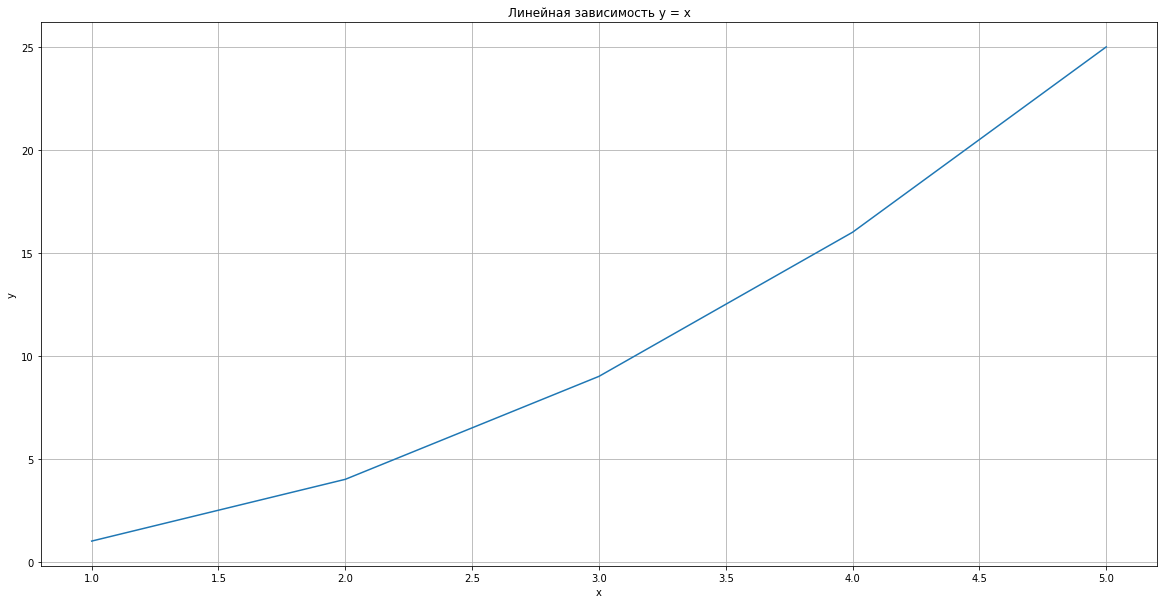

In [17]:
plt.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
plt.title("Линейная зависимость y = x") # заголовок
plt.xlabel("x") # ось абсцисс
plt.ylabel("y") # ось ординат
plt.grid()      # включение отображение сетки